In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 
import scanpy as sc 
import commot as ct

import sys
sys.path.append('../src')

In [4]:
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4.h5ad')
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')

adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mLND3-1_v4.h5ad')
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')

In [70]:
from spaceoracle.tools.utils import scale_adata

adata = scale_adata(adata, cell_size=10)
adata

0.7597104786028499


AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    uns: 'author_cell_type_colors', 'cell_type_2_colors', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

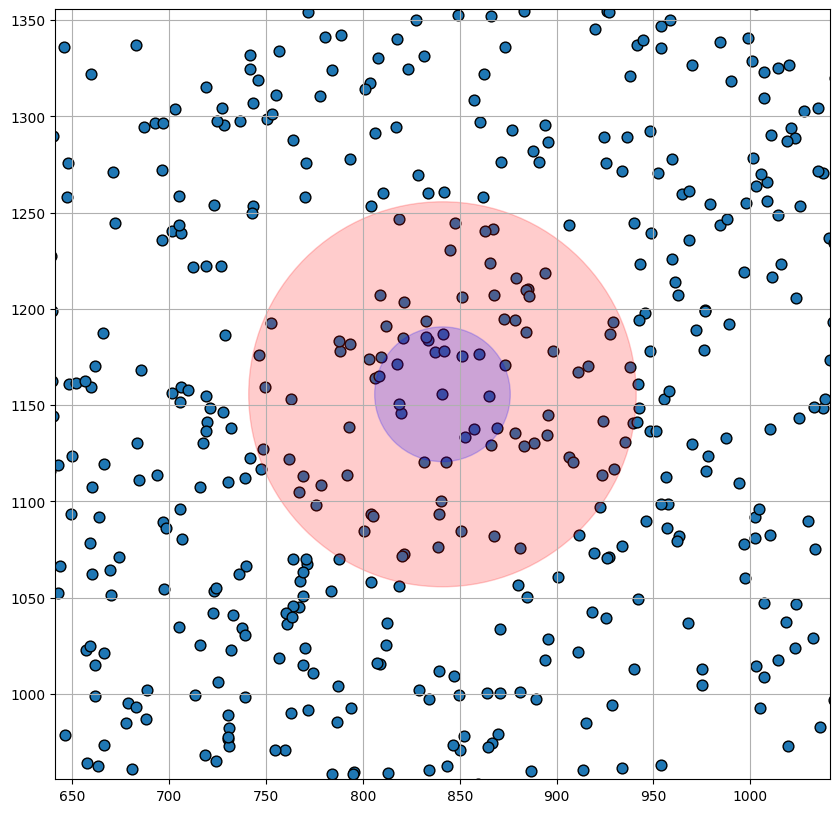

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.scatter(adata.obsm['spatial'][:, 0],  
    adata.obsm['spatial'][:, 1], s=60, linewidths=1, edgecolors='black')
plt.grid()


center_x, center_y = adata.obsm['spatial'][1400]
plt.xlim(center_x-200, center_x+200)
plt.ylim(center_y-200, center_y+200)

circle1 = plt.Circle((center_x, center_y), 100, color='r', fill=True, alpha=0.2)
circle2 = plt.Circle((center_x, center_y), 35, color='b', fill=True, alpha=0.2)

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

plt.show()

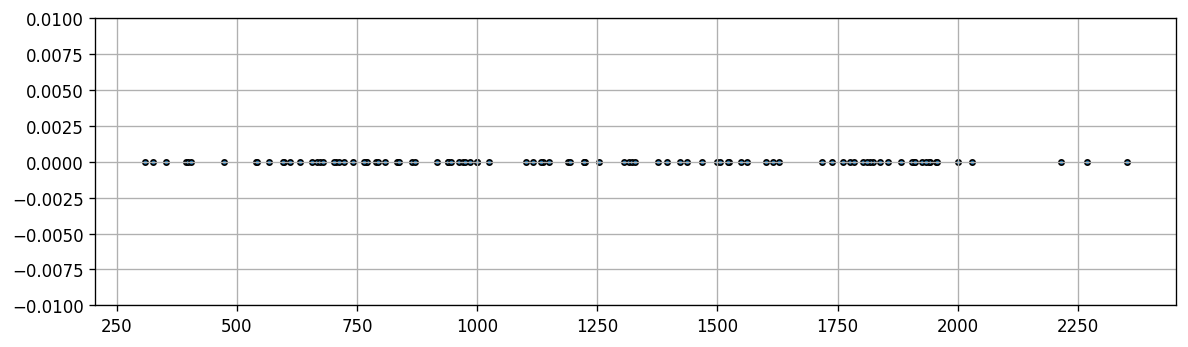

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3), dpi=120)

plt.scatter(adata.obsm['spatial'][:100, 0],  
    adata.obsm['spatial'][:100, 1]*0, s=10, 
    linewidths=1, edgecolors='black', alpha=1)
plt.grid()
plt.ylim(-0.01, 0.01)
plt.tight_layout()

In [11]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    # colinks_path='/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4_colinks.pkl',
    colinks_path='/Users/koush/Desktop/training_data/mLND3-1_v4_colinks.pkl',
    annot='cell_type_int'
)

from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata=adata,
    target_gene='Cd74',
    layer='imputed_count',
    cluster_annot='cell_type_int', 
    grn=co_grn,
    radius=100,
    contact_distance=30
)

In [13]:
estimator.fit(num_epochs=1, learning_rate=5e-3, score_threshold=0.1)

Fitting Cd74 with 204 modulators
	22 Transcription Factors
	130 Ligand-Receptor Pairs
	52 TranscriptionFactor-Ligand Pairs
0: 0.7831 | 0.8405
1: 0.7188 | 0.8121
2: 0.3854 | 0.7275
3: 0.3220 | 0.6740
4: 0.6498 | 0.8600
5: 0.6489 | 0.8252
6: 0.6059 | 0.7802


In [53]:
import seaborn as sns

In [228]:
from spaceoracle.prophets import Prophet

pythia = Prophet(
    adata=adata,
    models_dir='/Volumes/SSD/human_tonsil_v4',
    annot='cell_type_int',
    contact_distance=30,
    radius=200
)

pythia.compute_betas(subsample=10)
pythia.init_ligands_and_receptors()

100%|██████████| 10/10 [00:00<00:00, 109.87it/s]


In [218]:
df_ligrec = ct.pp.ligand_receptor_database(
                database='CellChat', 
                species='human', 
                signaling_type=None
            )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  
        

In [219]:
from spaceoracle.tools.network import expand_paired_interactions

df_ligrec = expand_paired_interactions(df_ligrec)

In [220]:
df_ligrec = df_ligrec[df_ligrec.ligand.isin(pythia.adata.var_names)]

In [221]:
pythia.ligands = df_ligrec[df_ligrec.ligand.isin(['ADGRE5', 'ALCAM', 'ANXA1', 'APP', 
       'CADM1', 'CD22', 'CD226',
       'FCER2', 'ENTPD1', 'CD40LG', 'CD6', 'CD80', 'CD86', 'CD96', 'CDH4',
       'CDH2', 'CDH5', 'CD1D', 'CD8A', 'CLEC2B', 'CD69', 'NFASC', 'CNTN1',
       'EFNA3', 'EFNA5', 'ICAM1', 'ICAM2', 'ICOSLG', 'ITGB2', 'JAM3',
       'LCK', 'HLA-G', 'NCAM1', 'NCAM2', 'NECTIN1', 'NECTIN3', 'NECTIN2',
       'NEGR1', 'DLL4', 'NRXN1', 'NRXN3', 'CD274', 'PDCD1LG2', 'PECAM1',
       'PTPRM', 'PVR', 'SELL', 'SELPLG', 'SEMA4C', 'SEMA4G', 'SEMA5A',
       'SEMA6D', 'SEMA6A', 'TIGIT', 'ITGA4', 'ITGB1', 'ITGA9', 'ITGB7',
       'VSIR'])][['ligand', 'signaling']].drop_duplicates(subset='ligand', keep='first').ligand.values

In [222]:
'SEMA4C' in pythia.ligands

True

In [229]:
rw_ligands = pythia._compute_weighted_ligands(adata.X)

In [232]:
rw_ligands

,ANGPTL1,ANXA1,BMP6,BMP7,BMP8A,C3,CCL19,CCL2,CCL20,CCL21,...,TNFSF11,TNFSF13B,TNFSF8,TNFSF9,VEGFC,WNT10A,WNT10B,WNT3,WNT4,WNT5B
NAME,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCTTG-1,129.657743,129.657743,4.810693e+00,18.743576,18.743576,18.743576,5.964491,5.964491,5.964491,4.795059e+00,...,3.225842,3.225842,17.925244,15.570006,15.570006,2.344023e+01,1.235211e+01,5.843941e-07,5.843941e-07,5.843941e-07
AAACCCAAGTGGACGT-1,331.260275,331.260275,1.071193e+00,17.553329,17.553329,17.553329,129.746746,129.746746,129.746746,9.057607e-03,...,6.184533,6.184533,2.848050,40.844005,40.844005,4.830899e-01,5.434868e+00,7.905324e+00,7.905324e+00,7.905324e+00
AAACCCACAGAAGTGC-1,274.154293,274.154293,1.567113e+00,2.090342,2.090342,2.090342,8.680482,8.680482,8.680482,6.210361e-01,...,7.791461,7.791461,3.352033,39.874891,39.874891,1.756343e-03,2.774352e-01,1.359232e-01,1.359232e-01,1.359232e-01
AAACCCAGTCATTGCA-1,201.821944,201.821944,8.684778e+00,6.714037,6.714037,6.714037,1.831781,1.831781,1.831781,9.263171e-04,...,12.902614,12.902614,49.680755,69.247472,69.247472,2.549769e+01,3.578435e-04,5.276483e-13,5.276483e-13,5.276483e-13
AAACCCATCATCGCAA-1,38.509532,38.509532,8.407056e+00,0.014005,0.014005,0.014005,17.009761,17.009761,17.009761,1.586809e-05,...,18.089039,18.089039,53.176264,3.638315,3.638315,1.471693e+01,3.307540e+00,3.281032e-10,3.281032e-10,3.281032e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGGGACTA-1,169.139763,169.139763,1.151520e+01,24.663459,24.663459,24.663459,4.296783,4.296783,4.296783,1.693450e-02,...,0.929523,0.929523,34.808267,23.048100,23.048100,2.971684e-02,1.931916e-02,1.857868e-18,1.857868e-18,1.857868e-18
TTTGTTGCATTGTAGC-1,30.427792,30.427792,1.185349e+01,70.999815,70.999815,70.999815,18.891933,18.891933,18.891933,1.704196e+00,...,3.289945,3.289945,32.301401,42.684454,42.684454,4.287782e-02,2.195421e-02,1.785530e-02,1.785530e-02,1.785530e-02
TTTGTTGGTACCACGC-1,146.017609,146.017609,3.796517e-07,5.183045,5.183045,5.183045,153.149470,153.149470,153.149470,3.592436e+00,...,4.077834,4.077834,3.304290,31.862642,31.862642,2.594582e-03,3.104362e-12,2.946276e+00,2.946276e+00,2.946276e+00


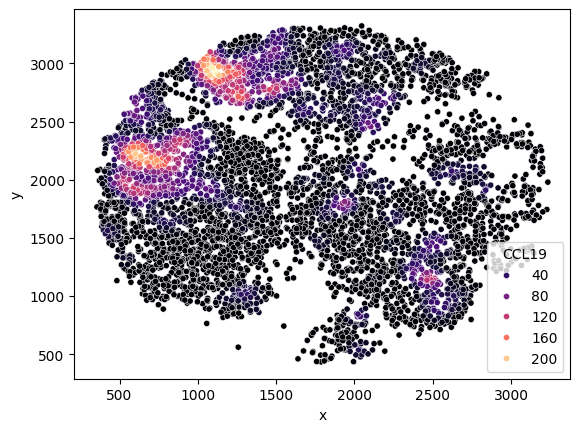

In [233]:
plt = sns.scatterplot(
    data=rw_ligands.join(pythia.xy), 
    x='x', y='y', hue='CCL19', 
    s=20, legend=True, palette='magma')

In [6]:
pythia.compute_betas(subsample=10)

100%|██████████| 10/10 [00:00<00:00, 11.12it/s]


In [78]:
from spaceoracle.beta import BetaFrame

In [81]:
bdf = BetaFrame.from_path(
    path='/Volumes/SSD/models_snrna_human_tonsil_v3/CLIP3_betadata.parquet', 
)

bdf

,beta0,beta_ARNTL,beta_BCL6,beta_BHLHE40,beta_BHLHE41,beta_EGR1,beta_EGR2,beta_GATA3,beta_GLIS3,beta_ID2,...,beta_TNF#STAT1,beta_FGF7#STAT1,beta_TNF#ZNF165,beta_FGF7#ZNF165,beta_EBI3#ZNF165,beta_BMP8A#ZNF165,beta_TNF#ZNF219,cell_type_int,x,y
NAME,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCTTG-1,0.095871,0.000248,0.000010,-0.000255,-3.052644e-05,3.849958e-05,-0.000003,0.000284,0.005978,-1.695649e-06,...,0.000233,0.000074,-0.000119,-0.000046,-0.000043,-0.000032,-0.000994,5,1733.213235,1665.039824
AAACCCAAGTGGACGT-1,0.018742,0.000131,0.001141,-0.000010,-1.037918e-04,2.312700e-05,0.000068,-0.000009,0.000061,-2.292521e-08,...,0.000022,-0.000090,0.000180,0.000171,0.000113,0.000134,-0.000091,12,519.377858,2220.266321
AAACCCACAGAAGTGC-1,0.065687,0.011719,-0.013343,0.036153,6.535902e-02,-4.717257e-03,0.057642,0.016542,-0.125368,1.525907e-02,...,-0.002818,-0.002497,-0.009860,0.007497,0.003058,-0.001410,0.001414,0,1064.296595,2158.266703
AAACCCAGTCATTGCA-1,0.042447,0.000355,0.002959,0.000042,6.548506e-04,-6.176894e-07,0.000489,0.000571,0.001083,3.301476e-04,...,0.000383,-0.000485,-0.002940,-0.000949,0.000506,-0.000464,-0.009606,2,1740.127314,3218.472808
AAACCCATCATCGCAA-1,0.068628,-0.000005,0.000252,0.000011,-7.854613e-07,5.197401e-07,-0.000003,0.000004,0.000006,-5.928855e-06,...,0.000046,-0.000012,-0.000094,0.000045,-0.000571,-0.000095,0.000026,1,930.600158,2892.947737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGGGACTA-1,0.069010,0.014415,-0.019994,0.044010,8.374164e-02,-7.126534e-03,0.071291,0.019022,-0.158769,1.695985e-02,...,-0.003014,-0.001807,-0.013690,0.008965,0.002311,-0.001761,0.001933,0,1699.607471,1920.402412
TTTGTTGCATTGTAGC-1,0.021443,0.000143,0.001258,-0.000011,-1.112205e-04,2.594131e-05,0.000074,-0.000010,0.000070,-1.448481e-08,...,0.000026,-0.000085,0.000191,0.000187,0.000131,0.000148,-0.000101,12,688.211974,2794.005768
TTTGTTGGTACCACGC-1,0.063009,0.013189,-0.011816,0.036438,6.040413e-02,-5.252043e-03,0.057243,0.015989,-0.122172,1.486673e-02,...,-0.002661,-0.002239,-0.010660,0.008557,0.002824,-0.001563,0.001531,0,1258.258885,2713.702000


In [83]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')

In [82]:
gex_df = adata.to_df(layer='imputed_count')